# Skript for Image Preprocessing in u-Shape3D format

In [1]:
from pathlib import Path
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [2]:
DATA_ROOT = Path("~/Documents/Projects/01_Bleb3D/Datensatz").expanduser()
control_Image = DATA_ROOT / "motif3DExampleDataFinal" / "testData" / "krasMV3" / "Cell1/1_CAM01_000000.tif"
Image = DATA_ROOT / "01_B2_BAR_3D_mCherry_CAAX-CFP_decon.tif"

control_Image.exists() # Should be TRUE
Image.exists()

True

The function `.expanduser` changes "~" to home + user (Returns home + user + Path)

In [3]:
control_Stack = tiff.imread(control_Image)
movie = tiff.imread(Image)


<tifffile.TiffFile '1_CAM01_000000.tif'> OME series failed to read '1_CAM02_000000.tif', raised FileNotFoundError(2, 'No such file or directory'). Missing data are zeroed
<tifffile.TiffFile '1_CAM01_000000.tif'> OME series failed to read 151 files


In [4]:
def check_img_data(tif_stack):
    print("Shape :", tif_stack.shape)
    print("dtype :", tif_stack.dtype)
    print("min / max :", tif_stack.min(), tif_stack.max())

check_img_data(control_Stack)
check_img_data(movie)


Shape : (151, 2, 512, 512)
dtype : uint16
min / max : 0 824
Shape : (5, 200, 3, 768, 270)
dtype : uint16
min / max : 0 3134


**Problem:** The format is not correct (T/Z/C/Y/X) we need (Z/C/Y/X). 

In [5]:
stack = movie[1]

print(stack.shape)

(200, 3, 768, 270)


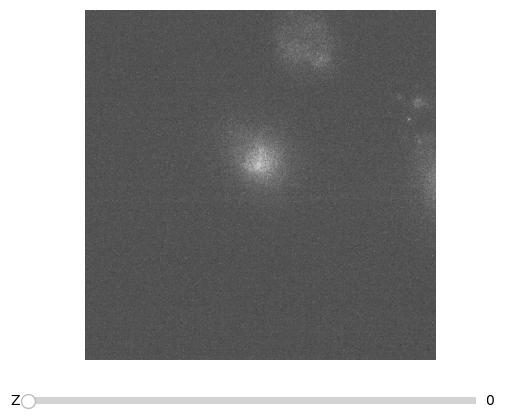

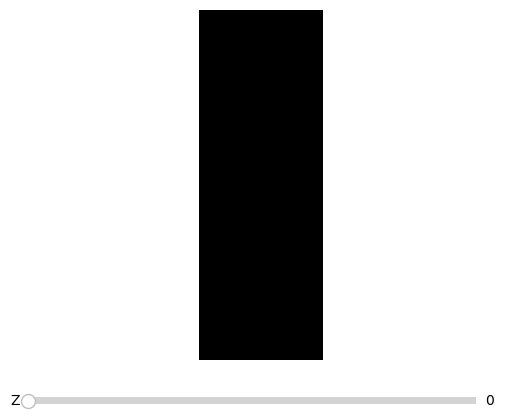

In [6]:
def slider_view(stack, ch=0):
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.15)
    im = ax.imshow(stack[0, ch], cmap="gray")
    ax.set_axis_off()

    ax_z = plt.axes([0.15, 0.05, 0.7, 0.03])
    s_z = Slider(ax_z, "Z",   0, stack.shape[0]-1, valinit=0, valstep=1)

    # --- Callback each time, if the slider is moved ---
    def update(val):
        z = int(s_z.val)
        im.set_data(stack[z, ch])
        ax.set_title(f"Z = {z}   |   C = {ch}")
        fig.canvas.draw_idle()

    s_z.on_changed(update)
    plt.show()

slider_view(control_Stack, ch=0)
slider_view(stack, ch=0)

The `Slider Library` is able to read the whole Np-Array which contains the Z-Stack and conjugate each Z-coordinate with the slider. The neasted funtion `update` defines the rule when the Slider ist updates (at every Z-Stack). With `cmap="grey"` (ax.imshow) you can convert the img to a grey scale img. 

After observing my own img, there is the problem, that all stacks were displayed in black. The Stack is shown with max = 3134, but 16bit can display values up to 65535. `matplotlib.imshow` uses with unit16 the full type-area of 0-65535 (2^16 for 16-bit) as standard contrast. With 3134 / 65532 = 5% is the brightest pixel very dark. 
Solution: Set vmax to 3134 for the first view 

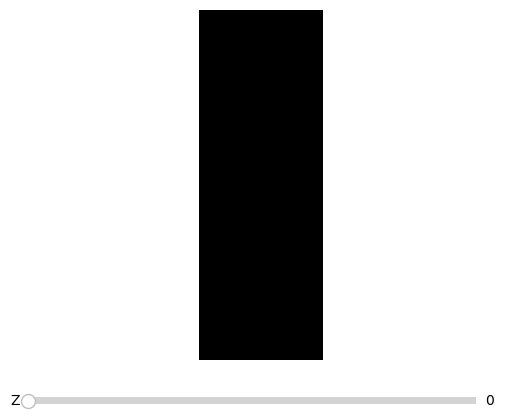

In [7]:
def slider_view_autocontrast(stack, ch=0):
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.15)
    ax.set_axis_off()

    ax_z = plt.axes([0.15, 0.05, 0.7, 0.03])
    s_z  = Slider(ax_z, "Z", 0, stack.shape[0]-1, valinit=0, valstep=1)

    def clim(frame):
        """1.–99. Perzentil als Kontrastgrenzen zurückgeben."""
        return np.percentile(frame, (1, 99))

    # --- show first img ---
    vmin, vmax = clim(stack[0, ch])
    im = ax.imshow(stack[0, ch], cmap='gray', vmin=vmin, vmax=vmax)

    
    def update(val):
        z = int(s_z.val)
        frame = stack[z, ch]

        vmin, vmax = clim(frame)      # new contrast 
        im.set_data(frame)
        im.set_clim(vmin, vmax)       # anwenden
        ax.set_title(f"Z = {z} | C = {ch}")
        fig.canvas.draw_idle()

    s_z.on_changed(update)
    plt.show()

slider_view_autocontrast(stack, ch=0)

In [8]:
out_dir = DATA_ROOT / "Preprocessed"
out_path = out_dir / "movie_t1_ZCYX.ome.tif"

tiff.imwrite(
    out_path,
    stack,
    metadata={"axes": "ZCYX"},
    ome=True,
    bigtiff=True
)

print("gespeichert:", out_path)

gespeichert: /Users/philippkaintoch/Documents/Projects/01_Bleb3D/Datensatz/Preprocessed/movie_t1_ZCYX.ome.tif


Introducing the preprocessed Imag into the u-Shape3D software resulted in an error Message: 

```
Error in Morphology3DPackage/sanityCheck (line 49)                                                                                                        
            assert(obj.owner_.is3D, errorMsg('MovieData is not 3D!'));      

```

With a look at the Data in Fiji it seems like there should be no problem with integrating the .tif image. Each dimension is annotated correctly and the Z-Axis is the same way as in the control image. In the enxt step I try to characterise both inputs more closely and compare them.

The Data Shape should looks like the following: 

```
[[[[ ... ]]]]
 ↑| | |  |
 || | |__ X-axis (columns)  → innermost
 || |____ Y-axis (rows)     → each 2-D image
 ||______ Z-axis (slices)   → stack of images
 |_______ C-axis (channels) → outermost level
```

--> or 5D if we include Time 

u-Shape3D wants **one multi-page TIFF per (channel x timepoint)** whose initial pages are only Z-Slices: 

```
<dataDir>/
├── ch1/
│   ├── stack_0001.tif   ← Z-stack of channel 1, time-point 1
│   ├── stack_0002.tif   ← (optional) time-point 2
│   └── …
├── ch2/
│   └── stack_0001.tif   ← Z-stack of channel 2, time-point 1
└── ch3/
    └── stack_0001.tif
```

**u-shape3D needs every channel in a single folder. Its possible to analysie (T/Z/Y/X)**

First I take the Raw image and try to run the script.


In [9]:
preprocessed_image_path = DATA_ROOT / "Preprocessed" / "movie_t1_ZCYX.ome.tif"

array_raw = tiff.imread(preprocessed_image_path)   

print("shape :", array_raw.shape)
print("dtype :", array_raw.dtype)
print("min / max :", array_raw.min(), array_raw.max())

C, Z, Y, X = array_raw.shape         # unpack sizes

slice10_ch0 = array_raw[9, 0]       # shape (Y, X)
#print(slice10_ch0)

# pixel at Z=12, C=1, Y=512, X=200
val = array_raw[12, 1, 512, 200]
#print(val)


#plt.imshow(array_raw[100, 0], cmap='gray', vmin=0, vmax=1000)
#plt.title("Channel 0, Z-slice 0")
#plt.axis('off')
#plt.show()




shape : (200, 3, 768, 270)
dtype : uint16
min / max : 0 2852


Worked mor or less for Deconvolution up to Mesh (without Smoothing). For extracting Meta-Data I wrote a quick skript. It is not possible with this version to extract the XY pixel Voxelsize. Voxelsize is defined as physical width/height of a single pixel on optical (detection the distance between two neighbouring pixels in the plane of the camera).

In [10]:
def inspect_and_export(tif_path: Path):

    tif_path = tif_path.expanduser()
    print(f"📂  File : {tif_path.name}")

    with tiff.TiffFile(tif_path) as tf:
        series = tf.series[0]
        axes = series.axes
        arr = series.asarray()
        ome = tf.ome_metadata 

        print(f"Axes: {axes}")
        print(f"Shape: {arr.shape}")

        
        imagej_metadata = tf.imagej_metadata
        z = imagej_metadata["spacing"]
        z = z * 1000
        print(f"Pixel Size Z (nm) = {z}")
        print(imagej_metadata)



path = Path("~/Documents/Projects/01_Bleb3D/Datensatz/01_B2_BAR_3D_mCherry_CAAX-CFP_decon.tif")


inspect_and_export(path)

📂  File : 01_B2_BAR_3D_mCherry_CAAX-CFP_decon.tif
Axes: TZCYX
Shape: (5, 200, 3, 768, 270)
Pixel Size Z (nm) = 205.84900000000002
{'ImageJ': '1.54p', 'images': 3000, 'channels': 3, 'slices': 200, 'frames': 5, 'hyperstack': True, 'mode': 'composite', 'unit': 'micron', 'spacing': 0.205849, 'loop': False, 'min': 0.0, 'max': 950.0, 'Ranges': (0.0, 950.0, 0.0, 2060.0, 0.0, 2728.0), 'LUTs': [array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

## Summary 

The state of the work is following: 
* u-shape3D needs each channel split (T/Z/X/Y) * 3 seperate Images
* Pixelsize: z= 205nM, XY = 103nM
* Not possible with smoothing in Mesh 

Segmentation.py is not necessary and does not extract all Metadata, which is fatal if f.e. Voxel size is necessary. TIFF_test1.0 is able to extract the Z-Pixels and is may extended to extract more Metadata (maybe an comparison algorithm). 



## Pipeline for Mesh Data Analysis 

In the next step the aim is to generate a Python pipeline to analyse thhe segmentation Data. 

In [11]:
from mat73 import loadmat

In [12]:
DATA_ROOT = Path("~/Documents/Projects/01_Bleb3D/Datensatz/Preprocessed/Output_u_shape3D_test7/Morphology/Analysis/Mesh/ch1").expanduser()

surface_data_path = DATA_ROOT / "surface_1_1.mat"
curvature_data_path = DATA_ROOT / "meanCurvature_1_1.mat"
neighbors_data_path = DATA_ROOT / "neighbors_1_1.mat"

print(surface_data_path)


/Users/philippkaintoch/Documents/Projects/01_Bleb3D/Datensatz/Preprocessed/Output_u_shape3D_test7/Morphology/Analysis/Mesh/ch1/surface_1_1.mat


In [13]:
surface_data = loadmat(surface_data_path) # Neasted Structure
curvature_data = loadmat(curvature_data_path)
neighbors_data = loadmat(neighbors_data_path)



In [14]:
import trimesh

In [15]:
def inspect_matlab_structure_mat73(surface_path):
    surface_data = loadmat(surface_path)

    print("Top-level keys:", list(surface_data.keys()))

    if "surface" in surface_data:
        surface = surface_data["surface"]
        print("Type of surface:", type(surface))

        # If it's a dictionary, explore its contents
        if isinstance(surface, dict):
            print("Surface is a dictionary with keys:", list(surface.keys()))

            # Inspect each field in detail
            for key, value in surface.items():
                print(f"Field: {key}")
                print(f"Type: {type(value)}")

                # If it's a numpy array, get more info
                if isinstance(value, np.ndarray):
                    print(f" Shape: {value.shape}")
                    print(f" Dtype: {value.dtype}")
                    print(f"  Min/Max: {value.min()} / {value.max()}")
                    print(value.ndim)
                    
                    print(f"First 5 elements: \n{value[:5]}")

        # If its a list
        elif isinstance(value, list):
            print(f"Lenght: {len(value)}")
            print(f"First element type: {type(value[0])}")

        # For other types 
        else:
            print(f"Value: {value}")

    else:
        print("\nSurface is not a dictionary!")

                


inspect_matlab_structure_mat73(surface_data_path)

Top-level keys: ['surface']
Type of surface: <class 'dict'>
Surface is a dictionary with keys: ['faces', 'vertices']
Field: faces
Type: <class 'numpy.ndarray'>
 Shape: (409272, 3)
 Dtype: float64
  Min/Max: 1.0 / 204490.0
2
First 5 elements: 
[[1. 2. 3.]
 [1. 4. 2.]
 [2. 4. 5.]
 [4. 6. 5.]
 [1. 3. 7.]]
Field: vertices
Type: <class 'numpy.ndarray'>
 Shape: (204490, 3)
 Dtype: float64
  Min/Max: 3.3269207166836776 / 707.8886506233663
2
First 5 elements: 
[[110.19241536 611.24040656  89.49847845]
 [110.18775016 611.26227078  89.54619943]
 [110.24138007 611.19417271  89.54543541]
 [110.21822964 611.31466901  89.57439965]
 [110.19020101 611.36425448  89.62590432]]


# Understanding u-shape3D Mesh Data

The mesh represents the 3D surface of a cell extracted from microscopy images. In my case:
* 204,490 vertices: Points on the cell surface in 3D space (X,Y,Z coordinates)
* 409,272 faces: Triangles connecting three vertices to form the surface

**1. Triangle Mesh**
* Each face is defined by 3 vertex indices
* Vertices are shared between multiple faces 
* Creates a continous surface representation

**2. Surface Segmentation**
The Software segments the surface into patches based on:
* Local curvature 
* Convexity/concavity
* Geometric features

**3. Feature Classifiaction**
Uses SVMs to classify patches as: 
* Blebs (convex motifs)
* Filopodia (thin portursions)
* Lamellipodia (sheet-like)
* Background surface 

Next its necessary to visualize specific regions to understand morphological features and load curvature data to see how the software measures local geometry to further investigate how features are detected. For this its necessary to explore SVM features used for classification. 

In [16]:
surface = surface_data['surface']

vertices = surface['vertices']
faces = surface['faces']